In [1]:
import os
import random
import torch
import numpy as np
import pickle as pkl
from analysis import *
import argparse
from sys import platform
# %load_ext autoreload
# %autoreload 2

In [2]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
torch.backends.cudnn.deterministics = True
torch.set_num_threads(1)

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())


print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 3090


In [4]:
# iv: image option
length = 440
channel = 128
min_CNN = 200
n_classes = 40
classes = range(n_classes)


In [5]:
if platform == "linux" or platform == "linux2":
    torch_models_dir = r"/media/mountHDD1/LanxHuyen/CVPR2017"
elif platform == "win32":
    torch_models_dir = r"D:\Data\CVPR2021-02785\CVPR2021-02785\preprocessed\torch_models"
block_splits_all = '/media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth' 
eeg_raw = '/media/mountHDD1/LanxHuyen/CVPR2017/eeg_5_95_std.pth'
# block_splits_all, block_splits_single, eeg_14_70, eeg_55_95, eeg_5_95, eeg_raw = os.listdir(torch_models_dir)
# print(os.listdir(torch_models_dir))

In [6]:
# eeg_dataset = os.path.join(torch_models_dir, eeg_5_95)
# splits_all_path = os.path.join(torch_models_dir, block_splits_all)
eeg_dataset = eeg_raw
splits_all_path = block_splits_all

print(eeg_dataset,'\n', splits_all_path)

/media/mountHDD1/LanxHuyen/CVPR2017/eeg_5_95_std.pth 
 /media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth


In [7]:
splits_all = torch.load(splits_all_path)
# splits_single = torch.load(splits_single_path)

In [8]:
print(len(splits_all['splits']))
print(len(splits_all['splits'][0]))

print(len(splits_all['splits'][5]['train']))
print(len(splits_all['splits'][5]['val']))
print(len(splits_all['splits'][5]['test']))
print(splits_all['splits'][0]['train'][:40])
print(splits_all['splits'][1]['train'][:40])
print(splits_all['splits'][2]['train'][:10])
print(splits_all['splits'][3]['train'][:10])


6
3
7984
1996
1985
[0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 29, 33, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 51, 52, 54, 55]
[1, 2, 3, 4, 6, 8, 9, 12, 13, 20, 25, 26, 27, 28, 30, 32, 33, 35, 37, 38, 39, 40, 44, 45, 46, 50, 52, 54, 56, 58, 59, 60, 62, 65, 68, 72, 73, 74, 76, 81]
[2, 3, 4, 5, 6, 7, 8, 10, 11, 13]
[1, 2, 4, 7, 9, 10, 12, 13, 14, 15]


In [9]:
eeg_loaded = torch.load(eeg_dataset)

In [10]:
print(len(eeg_loaded))
print(eeg_loaded.keys())
dataset, labels, images = [eeg_loaded[k] for k in eeg_loaded.keys()]
print(len(labels))
print(len(images))
print(len(dataset))
print(*labels)
print(images[0])
print(dataset[0]['eeg'].shape)
print(dataset[1950])
#Trial 0-1995 - subject 4
#Trial 1996 - 3980 - subject 1
#Trial 3981 - 5976 - subject 6
#Trial 5977 - 7972 - subject 3
#Trial 7973 - 9968 - subject 2
#Trial 9969 - 11964 - subject 5

3
dict_keys(['dataset', 'labels', 'images'])
40
1996
11965
n02389026 n03888257 n03584829 n02607072 n03297495 n03063599 n03792782 n04086273 n02510455 n11939491 n02951358 n02281787 n02106662 n04120489 n03590841 n02992529 n03445777 n03180011 n02906734 n07873807 n03773504 n02492035 n03982430 n03709823 n03100240 n03376595 n03877472 n03775071 n03272010 n04069434 n03452741 n03792972 n07753592 n13054560 n03197337 n02504458 n02690373 n03272562 n04044716 n02124075
n02951358_31190
torch.Size([128, 500])
{'eeg': tensor([[ 0.0144, -0.0790, -0.1815,  ..., -0.0770, -0.0619, -0.0257],
        [ 0.0182, -0.0712, -0.1688,  ..., -0.0241, -0.0334, -0.0179],
        [-0.0080, -0.0906, -0.1497,  ..., -0.1995, -0.0860,  0.0092],
        ...,
        [ 0.0033, -0.1479, -0.2861,  ...,  0.0940,  0.0406, -0.0049],
        [-0.0047, -0.0076, -0.0117,  ..., -0.0048, -0.0059, -0.0056],
        [ 0.0031, -0.0257, -0.0693,  ..., -0.0478, -0.0398, -0.0109]]), 'image': 1950, 'label': 16, 'subject': 4}


In [11]:
def generate_noise(signal_length, noise_level=0.1):
    noise = np.random.normal(0, noise_level, signal_length)
    return noise

# Define a function to augment an EEG sample
def augment_eeg(eeg_data, noise_level=0.1):
    noise_shape = eeg_data.shape  # Get the shape of the EEG data
    augmented_eeg = eeg_data + generate_noise(noise_shape, noise_level)
    return augmented_eeg
# Parameters for data augmentation
num_augmentations = 2  # Number of augmentations to create
noise_level = 0.1  # Adjust this based on your dataset

# Create a new dataset to store augmented data
augmented_dataset = []

# Iterate through the original dataset
for sample in dataset:
    augmented_samples = []
    
    # Original sample
    original_eeg = sample['eeg']
    image = sample['image']
    label = sample['label']
    subject = sample['subject']
    augmented_samples.append(original_eeg)
    
    # Apply data augmentation multiple times
    for _ in range(num_augmentations):
        augmented_eeg = augment_eeg(original_eeg, noise_level)
        augmented_samples.append(augmented_eeg)
    
    # Add all augmented samples to the new dataset
    for augmented_sample in augmented_samples:
        augmented_data_point = {
            'eeg': augmented_sample,
            'image': image,
            'label': label,
            'subject': subject
            # Other relevant fields if any
        }
        augmented_dataset.append(augmented_data_point)

In [12]:
print(len(augmented_dataset))

35895


In [13]:
print(augmented_dataset[0])

{'eeg': tensor([[-0.0098,  0.0195,  0.0620,  ...,  0.0638,  0.0120, -0.0118],
        [-0.0045,  0.1303,  0.2673,  ...,  0.0894,  0.0342, -0.0082],
        [ 0.0215, -0.2017, -0.4305,  ..., -0.2022, -0.0940,  0.0188],
        ...,
        [ 0.0160,  0.0707,  0.1005,  ...,  0.2066,  0.1156,  0.0036],
        [-0.0046, -0.0084, -0.0119,  ...,  0.0007, -0.0026, -0.0053],
        [ 0.0040,  0.0419,  0.0665,  ...,  0.0765,  0.0309, -0.0063]]), 'image': 0, 'label': 10, 'subject': 4}


In [14]:
print(augmented_dataset[1])

{'eeg': tensor([[ 0.0375, -0.0487,  0.0862,  ...,  0.2022,  0.0043, -0.1030],
        [-0.0760, -0.0158,  0.4077,  ...,  0.1752,  0.1341, -0.1306],
        [ 0.2104, -0.0283, -0.4335,  ..., -0.0905, -0.0174, -0.1627],
        ...,
        [-0.0122, -0.0930, -0.0097,  ...,  0.0919,  0.0581,  0.0293],
        [-0.0473, -0.0280,  0.0347,  ..., -0.0084,  0.1699, -0.1054],
        [-0.0310, -0.0617,  0.0212,  ..., -0.0503,  0.0347, -0.0970]],
       dtype=torch.float64), 'image': 0, 'label': 10, 'subject': 4}


In [15]:
print(augmented_dataset[2])

{'eeg': tensor([[-0.0242, -0.2267,  0.0638,  ...,  0.1010,  0.0857, -0.0638],
        [-0.0426,  0.1122,  0.1977,  ..., -0.0046,  0.1610,  0.0938],
        [-0.0244, -0.2329, -0.3111,  ..., -0.2177, -0.0396,  0.0882],
        ...,
        [ 0.0321, -0.1054,  0.3396,  ...,  0.3829,  0.2728,  0.0427],
        [-0.0667, -0.0399,  0.0166,  ..., -0.0665, -0.0746,  0.0511],
        [ 0.1039,  0.0327,  0.0544,  ..., -0.1157,  0.1764, -0.1368]],
       dtype=torch.float64), 'image': 0, 'label': 10, 'subject': 4}


In [16]:
print(augmented_dataset[4]['eeg'].shape)

torch.Size([128, 511])


In [17]:
import matplotlib.pyplot as plt

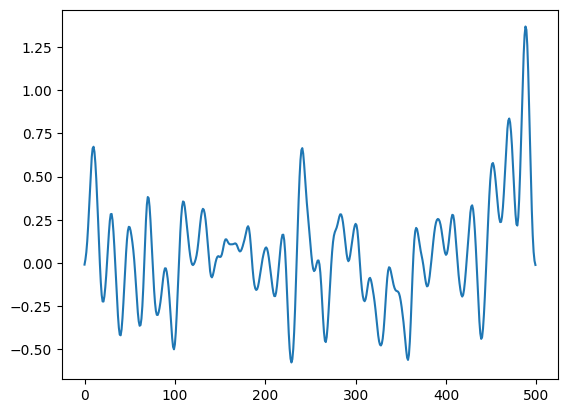

In [18]:
plt.plot(augmented_dataset[0]['eeg'][0])

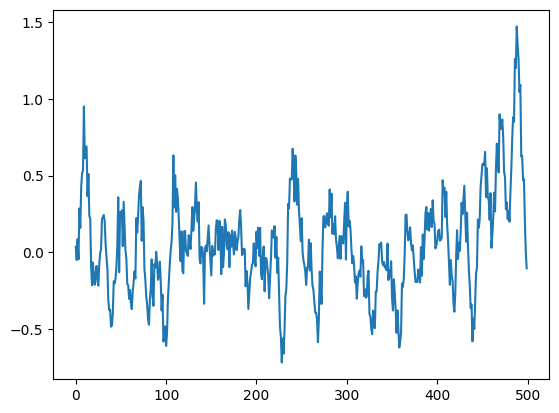

In [19]:
plt.plot(augmented_dataset[1]['eeg'][0])

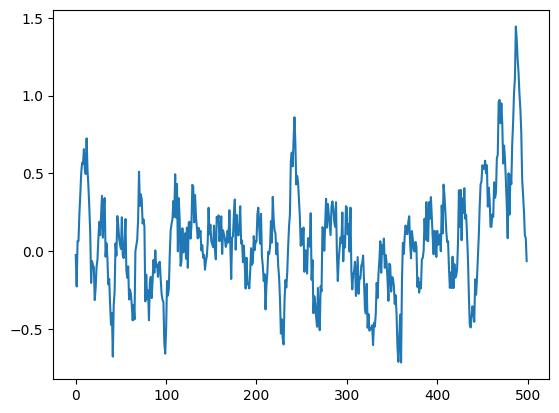

In [20]:
plt.plot(augmented_dataset[2]['eeg'][0])

In [ ]:
import torch
import torch.nn.functional as F
import cv2
import os

# Check if GPU is available, and if not, fall back to CPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

output_directory = '/media/mountHDD1/LanxHuyen/CVPR2017'

# Define constants
output_shape = (512, 440)  # Resized image shape

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Method 1: Creating grayscale heatmaps for each trial
def process_method_1(eeg_data):
    normalized_data = (eeg_data - eeg_data.min()) / (eeg_data.max() - eeg_data.min())
    grayscale_images = (normalized_data * 255).to(torch.uint8)
    stacked_images = grayscale_images.unsqueeze(0).repeat(1, 1, 1, 1)  # Stack 3 times along the channel axis
    resized_images = F.interpolate(stacked_images, size=output_shape[:2], mode='bilinear', align_corners=False)
    return resized_images[0].squeeze(0).float()

# Move the model and data to the GPU if available
for sample in augmented_dataset:
    sample['eeg'] = process_method_1(sample['eeg'])

print("Processed Images Shape:", augmented_dataset[0]['eeg'].size())
# # Apply method 1 to each tensor in eeg_tensors
# processed_images = [process_method_1(eeg_tensor) for eeg_tensor in eeg_tensors]
# # Concatenate processed images along a new dimension
# concatenated_images = torch.stack(processed_images)
# Save the concatenated tensor as a .pth file
# output_filename = os.path.join(output_directory, "eeg_heatmaps_55_95.pth")
# torch.save(dataset, output_filename)

In [ ]:
print(len(dataset))

In [ ]:
print(dataset[3])

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
# Choose an index for the image you want to visualize
image_index = 2  # Change this to the index you want to visualize

# Retrieve the processed image tensor from the dataset
for image_index in range (3,6):
    processed_image_tensor = augmented_dataset[image_index]['eeg']

# Convert the processed image tensor to a NumPy array
    processed_image_np = processed_image_tensor.cpu().numpy()

# Convert the NumPy array to an image in the range [0, 255]
# processed_image_np = processed_image_np.transpose(1, 2, 0)  # Channels-last format
# processed_image_np = processed_image_np.squeeze()  # Remove singleton dimensions
    processed_image_np = processed_image_np.astype('uint8')

# Using Matplotlib
    plt.imshow(processed_image_np, cmap='gray')  # Display as grayscale
    plt.axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already processed the images using the process_method_1 function
# processed_images = [process_method_1(eeg_tensor) for eeg_tensor in eeg_tensors]

# Choose the index of the image you want to plot (e.g., index 0)
image_index = 1100

# Convert the processed image to a numpy array and transpose dimensions
# numpy_image = processed_images[image_index].numpy().transpose(1, 2, 0)
numpy_image = processed_images[image_index].numpy()

# Plot the processed image
plt.imshow(numpy_image, cmap='gray')  # Display as grayscale
plt.title(f"Processed Image {image_index + 1}")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
eeg_length = np.zeros(len(dataset))
for i in range(len(dataset)):
    eeg_length[i] = list(dataset[i]['eeg'].size())[1]

In [ ]:
sub_length = np.empty(len(dataset))
for i in range(len(dataset)):
    sub_length[i] = dataset[i]['subject']

In [ ]:
# print(dataset['eeg'].size())
import torch.nn.functional as F
desired_size = 500

new_dataset = torch.zeros(len(dataset), 128, desired_size)

for i in range(len(dataset)):
    eeg_data = dataset[i]['eeg']

    # Convert the tensor to torch.float32
    eeg_data_float = eeg_data.to(torch.float32)

    # Resize using linear interpolation
    resized_eeg = F.interpolate(eeg_data_float.unsqueeze(0), size=desired_size, mode='linear')

    # Convert the resized tensor back to the original data type (if needed)
    resized_eeg = resized_eeg.to(eeg_data.dtype)

    new_dataset[i, :, :] = resized_eeg.squeeze(0)

In [ ]:
new_dataset.size()

In [ ]:
for j in range(1996):
    filtered_dataset_4 = new_dataset[j]
for k in range(1996,3980):
    filtered_dataset_1 = new_dataset[k]
for l in range(3981,5976):
    filtered_dataset_6 = new_dataset[l]
for m in range(5977,7972):
    filtered_dataset_3 = new_dataset[m]
for n in range(7973,9968):
    filtered_dataset_2 = new_dataset[n]
for o in range(9969,11964):
    filtered_dataset_5 = new_dataset[o]

In [ ]:
print(filtered_dataset_4.size())
print(filtered_dataset_1.size())
print(filtered_dataset_6.size())
print(filtered_dataset_3.size())
print(filtered_dataset_2.size())
print(filtered_dataset_5.size())

In [ ]:
filtered_dataset = torch.stack((filtered_dataset_4,filtered_dataset_1,filtered_dataset_6,filtered_dataset_3,filtered_dataset_2,filtered_dataset_5),dim = 0)

In [ ]:
filtered_dataset.size()

In [ ]:
print(filtered_dataset)

In [ ]:
# for i in range(len(new_dataset)):
#     image_index = dataset[i]['image']
#     subject_index = dataset[i]['subject']
#     filtered_dataset[subject_index-1, :, :] = new_dataset[image_index]

In [ ]:
keys = ('eeg', 'images', 'label')
for i in range(len(new_dataset)):
    value = (filtered_dataset, dataset

In [ ]:
# for i in range(len(dataset)):
#     # Normalize each component using mean and stddev
#    new_dataset[i, :, :] = (new_dataset[i, :, :] - means) / stddevs

In [ ]:
# print(new_dataset.size())
# print(new_dataset[0])

# import matplotlib.pyplot as plt
# plt.plot(new_dataset[0][0])

In [ ]:
heatmap_image = filtered_dataset

In [ ]:
heatmap_image.size()

In [ ]:
# Normalize the heatmap image to [0, 255]
heatmap_image_normalized = ((heatmap_image - heatmap_image.min()) /
                            (heatmap_image.max() - heatmap_image.min()) * 255).byte()

In [ ]:
# Convert the tensor to a NumPy array for plotting
heatmap_image_np = heatmap_image_normalized.numpy()

# Display the heatmap image
plt.imshow(heatmap_image_np, cmap='gray')
plt.title("EEG Grayscale Heatmap Image")
plt.colorbar()
plt.show()

In [ ]:
print(heatmap_image_np)
print(heatmap_image_np.shape)

In [ ]:
for i in range(len(dataset)):
    dataset[i]['eeg'] = new_dataset[i]

In [ ]:
print(dataset[2])

In [ ]:
opt = {
    # Dataset options
#     "iv": "image",
#     "offset": None,
    "results_file": "results.pkl",
    "subject": 0,
    "time_low": 20,
    "time_high": 460,
#     "run": "none",
    "eeg_dataset": eeg_dataset,
    "model_type": "model10",
    "splits_path": splits_all_path,
    "split_num": 0,
    "split_name": "train",
#     "fold": 5,
    #Training options
    "batch_size": 16,
    "optim": "Adam",
    "learning_rate": 0.001,
    "learning_rate_decay_by": 0.5,
    "learning_rate_decay_every": 10,
    "epochs": 100,
    "GPUindex": 0,
    "kind":"from-scratch",
    #Backend options
    "no_cuda": False,
    "classifier": None
}
opt = argparse.Namespace(**opt)
print(opt)

In [ ]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
# from data_loader import EEGDataset, Splitter, SplitterWithData
from data_loader_CVPR2017 import EEGDataset, Splitter
from EEG_Encoder.LSTM import classifier_LSTM
from EEG_Encoder.CNN import classifier_CNN
from EEG_Encoder.EEGNet import classifier_EEGNet
from EEG_Encoder.SyncNet import classifier_SyncNet
from EEG_Encoder.EEGChannelNet import classifier_EEGChannelNet
from EEG_Encoder.net_generator import Classifier
from EEG_Encoder.net_trainer import net_trainer
from p_values import *
from torchinfo import summary

In [ ]:
def load_dataset(
#              offset,
             eeg_dataset,
             splits_path,
             split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             kind="from-scratch"):        
    # Load dataset
    dataset = EEGDataset(opt, eeg_dataset)
    print("DONE: LOAD DATASET")
#     # Create loaders for LSTM/MLP/CNN/SCNN/EEGNet/SyncNet/EEGChannelNet
#     if kind=="from-scratch":
#         relabel = False
#     if kind=="incremental":
#         relabel = False
#     if kind=="no-model-file":
#         relabel = True
    splitter = {split: Splitter(dataset,
                    splits_path,
                    split_num,
                    split_name=split) for split in ["train", "val", "test"]}
    loaders = {split: DataLoader(
                        splitter[split],
                        batch_size = batch_size,
                        drop_last = False,
                        shuffle = True)
                    for split in ["train", "val", "test"]}
    channel_idx = None    
    print("DONE: Create loaders for model")            
    return dataset, loaders, splitter

In [ ]:
# Options
opt.classifier = "LSTM4"
opt.batch_size = 16
# opt.kind = "from-scratch"
# opt.run = "imagenet40-1000"
# opt.fold = 5

In [ ]:
dataset, loaders, splitter = load_dataset(
#              offset,
             opt.eeg_dataset,
             opt.splits_path,
             opt.split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             opt.batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             opt.kind)

In [ ]:
# loaders: divide the splits data in each fold with batch_size
# Each fold has {train: 8000 idx, val: 2000 idx, test: 2000 idx}
# Each loader batch has {train: 2000 idx, val: 250 idx, test: 250 idx}
print(type(dataset))
print(type(loaders))
print(len(loaders), [len(loaders[name]) for name in ["train", "val", "test"] ])
# for i, (input, target) in enumerate(loaders["train"]):
#     if i<20:
#         print(f"{i+1}: Target size: {target.size()}; input size: {input.size()}")
for i in range(0, 40):
    eeg, label_val = splitter["val"][i]
    eeg, label_train = splitter["train"][i]
    print(f"{i+1}: Label val: {label_val}; label train: {label_train}")


In [ ]:
net, nonclasses = Classifier(
                 n_classes,
                 classes,
                 opt.classifier,
                 opt.GPUindex,
                 length,
                 channel,
                 min_CNN,
                 opt.kind)
# print(len(nonclasses))
summary(net, input_size=(1,128, 440))

In [ ]:
model_path = (   "CVPR2017-" +
                  opt.classifier+
                  "-"+
                  str(length)+
                  "-"+
                  str(channel)+
                  "-"+
                  'Retest' )
print(model_path)

In [ ]:
print(opt)

In [ ]:
channel_idx=None
non_classes=None
if opt.kind=="from-scratch":
    results = net_trainer(
            net,
            loaders,
            opt,
            channel_idx,
            nonclasses,
            None,
            True,
            model_path,
            print_every_train = 100,
            print_every_val = 125)

In [ ]:
# val = results["val_acc"]
# # test = results["test_acc"]

# print("Validation accuracy: ", val)
# # print("Test accuracy: ", test)

In [ ]:
print(accuracy_val)